In [52]:
from __future__ import (absolute_import, division,
                        print_function, unicode_literals)
# отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

# будем отображать графики прямо в jupyter'e
%pylab inline

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5
import pandas as pd
import seaborn as sns

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.graph_objs as go

init_notebook_mode(connected=True)

import pandahouse as ph

Populating the interactive namespace from numpy and matplotlib


In [53]:
HOST = ''
DB = ''

In [54]:
#чтение данных с кликхауса или файла
def readClickHouse(query = '', fileName = '1.csv', host = HOST, db = DB):
    if host != '':
        data = ph.read_clickhouse(query, connection={'host': host, 'database': db})
        open(fileName, 'w').write(data.to_csv())
    else:
        try:
            f = open(fileName)
        except IOError as e:
            print('Не удалось открыть файл')
        else:
            data = pd.read_csv(fileName, sep = ',')
            data = data[[x for x in data.columns if x != 'Unnamed: 0']]
    return data

In [55]:
#запрос первый
def getQuery1():
    depth = [1, 2, 5, 10, 15, 20]
    query = 'select\n'
    query += 'offer_id,\n'
    query += 'page_type,\n'
    
    depLast = 0
    for dep in depth:
        query += 'uniqIf(session_id, '
        query += str(depLast)
        query += ' < depth and depth <= ' 
        query += str(dep)
        query += ') as s'
        query += str(dep)
        query += ',\n'
        depLast = dep
    
    query += 'uniqIf(session_id, ' + str(depLast) + ' < depth) as sOver\n'
    query += 'from {db}.rtb WHERE date = today()\n'
    query += 'group by offer_id, page_type\n'
    query += 'order by offer_id, page_type'
    return query

In [56]:
df1 = readClickHouse(getQuery1(), 'query1.csv')

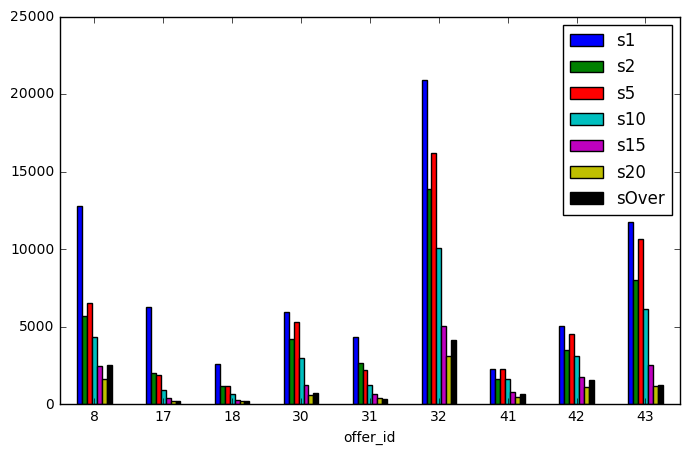

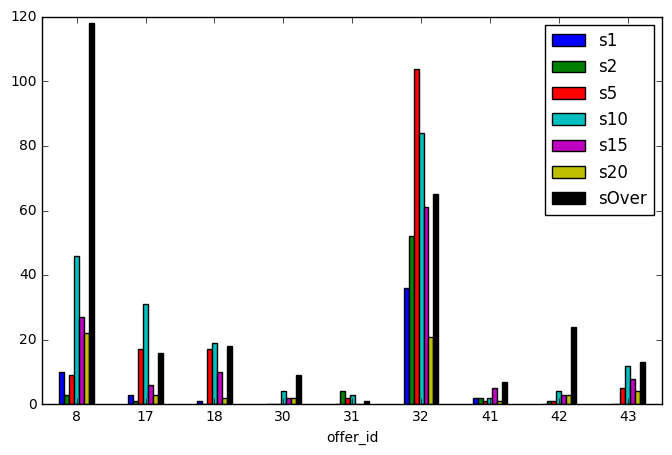

In [57]:
#группируем по офферам и суммируем на всех страницах
df1.groupby('offer_id').sum().plot(kind='bar', rot=0)
#группируем по офферам, страница typ
df1[df1['page_type'] == 'typ'].groupby('offer_id').sum().plot(kind='bar', rot=0)

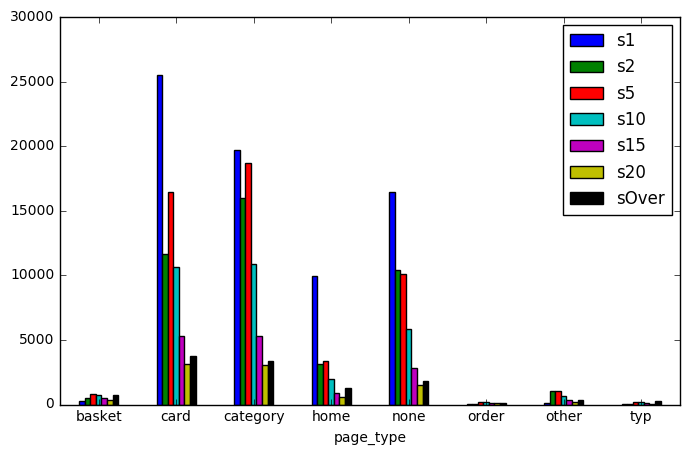

In [58]:
#выбираем колонки кроме оффера и группируем по типу страницы после суммируем по все оферам
df1[[x for x in df1.columns if x != 'offer_id']].groupby('page_type').sum().plot(kind='bar', rot=0)

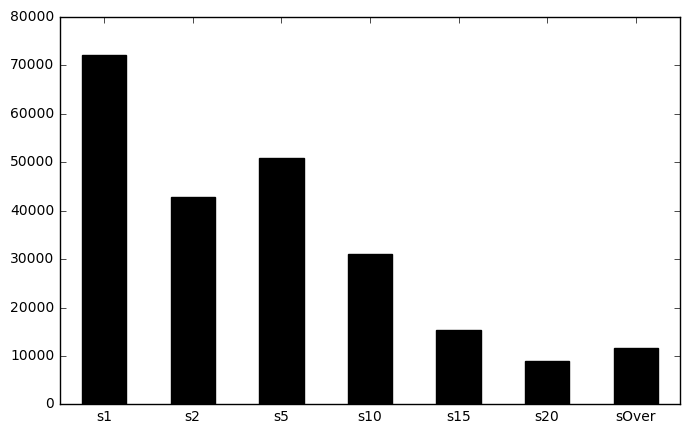

In [59]:
#сумма всех страниц по всем офферам
df1.groupby('offer_id').sum().sum().plot(kind='bar', rot=0, color='black')

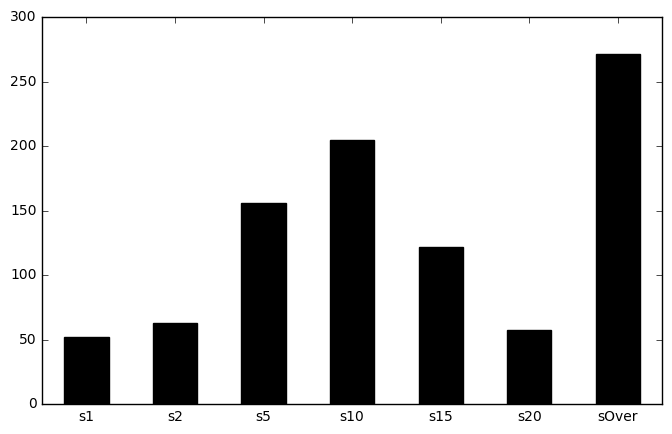

In [60]:
#сумма по всем офферам, только страница typ
df1[df1['page_type'] == 'typ'].groupby('offer_id').sum().sum().plot(kind='bar', rot=0, color='black')

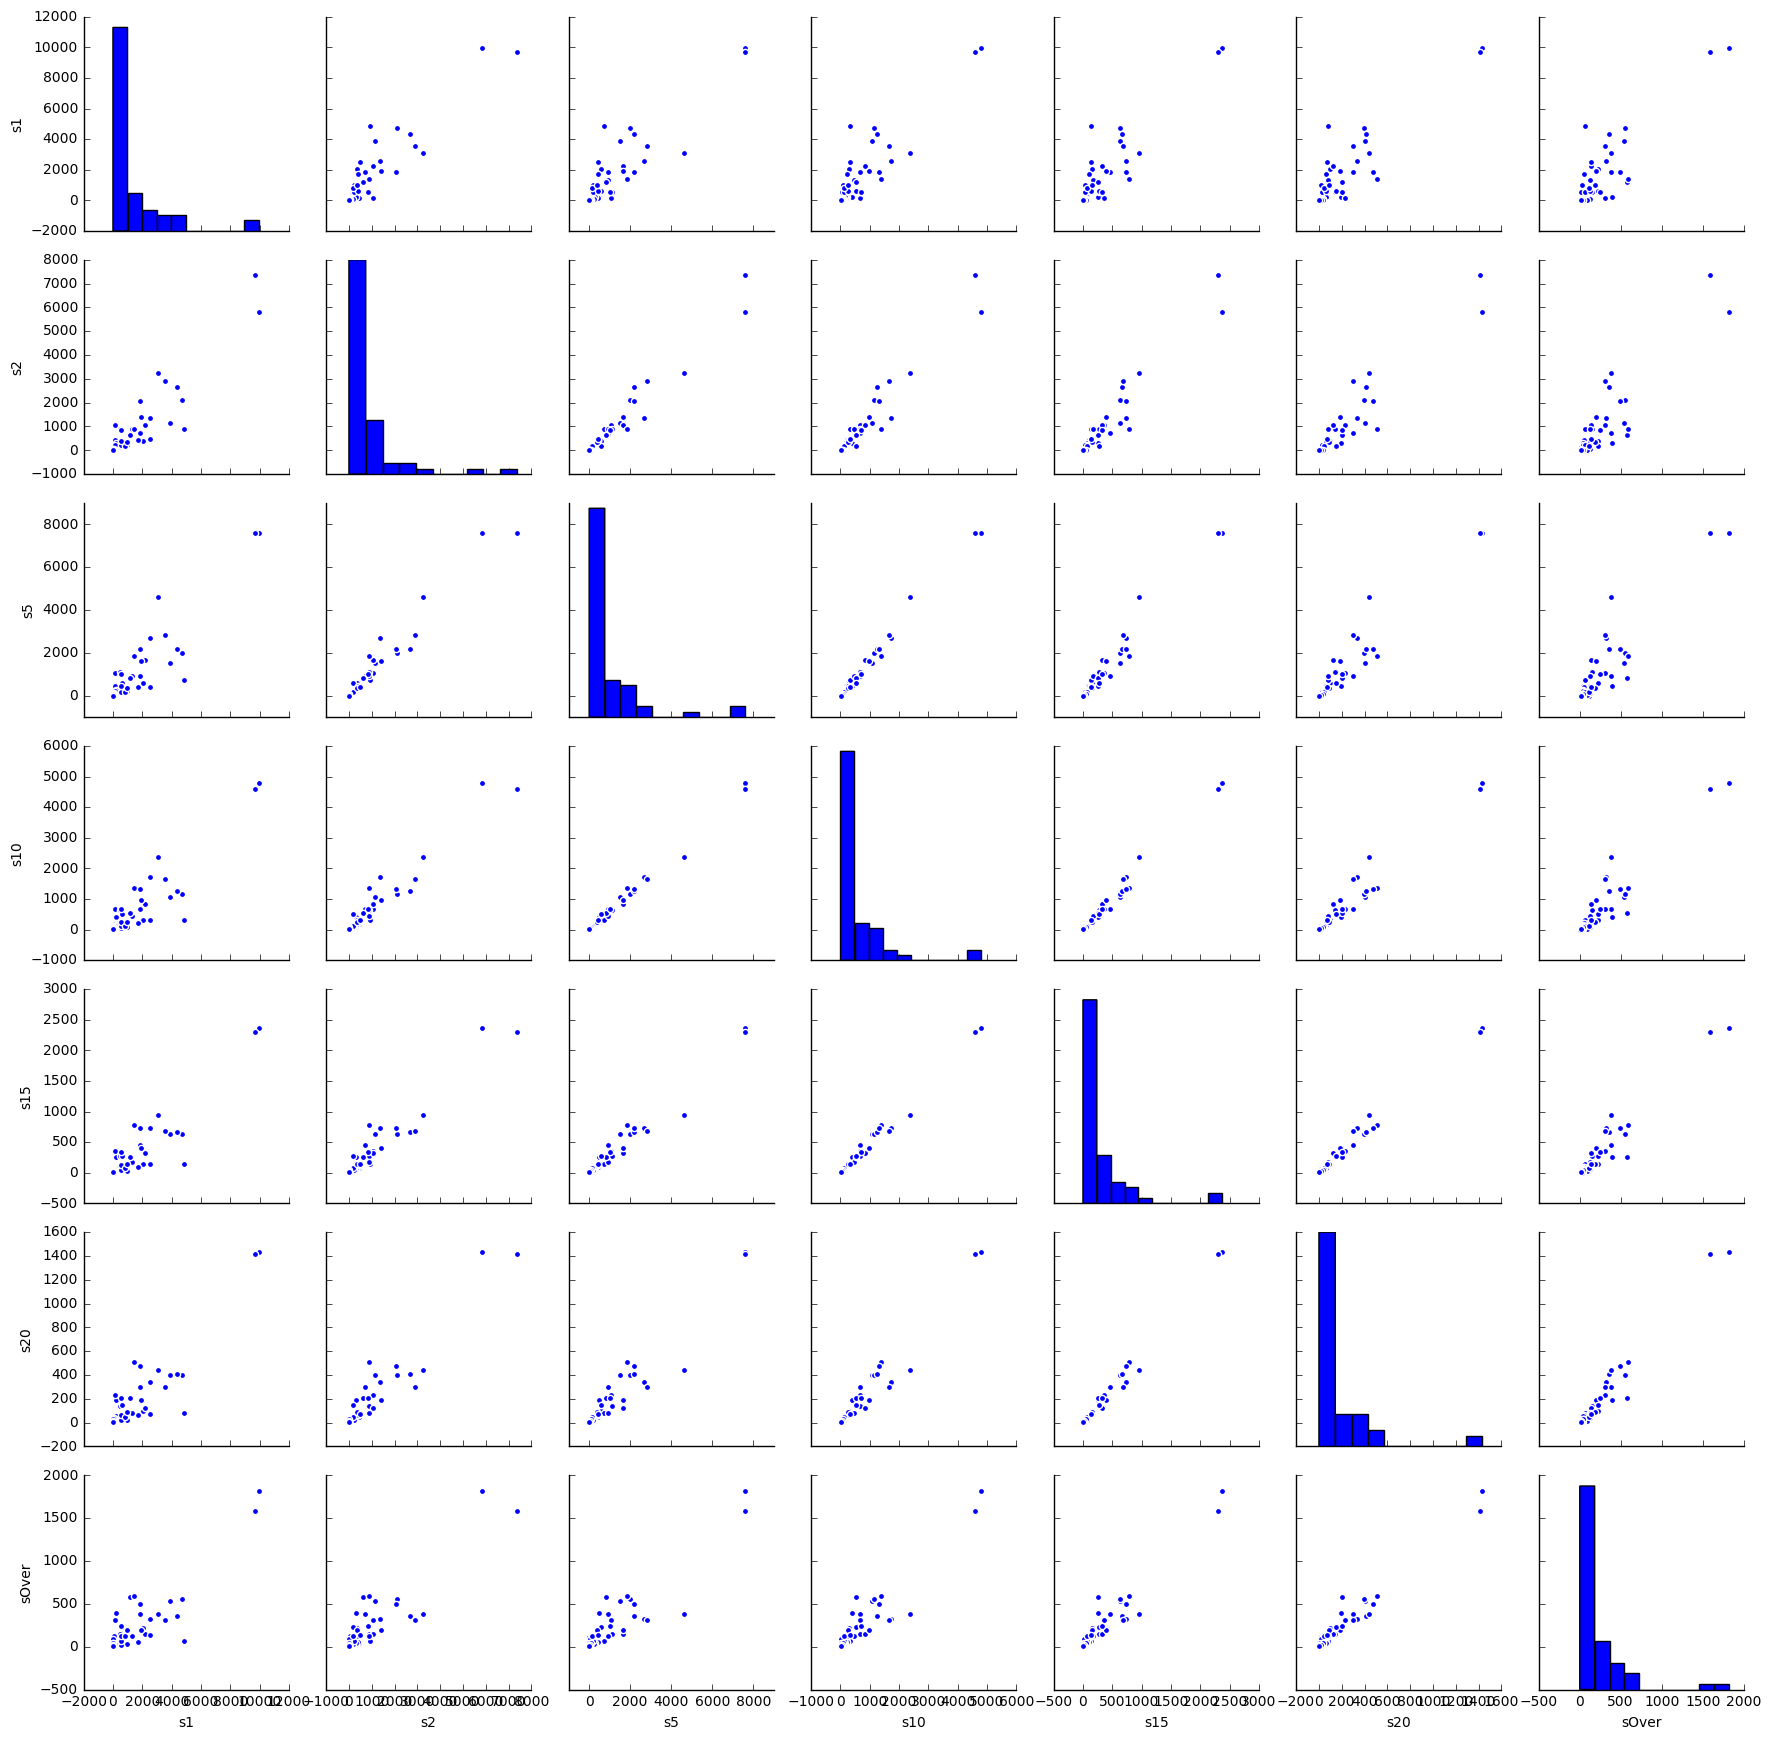

In [62]:
cols = ['s1', 's2', 's5', 's10', 's15', 's20', 'sOver']
sns_plot = sns.pairplot(df1[cols])
sns_plot.savefig('pairplot.png') 

In [63]:
#запрос 2
def getQuery2():
    return '''
        select
        offer_id,
        max_depth,
        count(*) as sessions_count,
        countIf(typ_count > 0) as sessions_typ_count

        from (select 
            offer_id, 
            session_id,
            min(datetime) as start_time,
            max(datetime) as end_time,
            max(datetime) - min(datetime) as duration,
            count(*) as clicks_count,
            max(depth) as max_depth,
            countIf(order_id != '') as orders_count,
            countIf(page_type = 'typ') as typ_count,
            countIf(page_type = 'basket') as basket_count,
            anyLast(source) as last_source
            from {db}.rtb
            group by offer_id, session_id
            ) visits 
        group by offer_id, max_depth
        order by offer_id, max_depth
'''

def getQuery2All():
    return '''
        select
        max_depth,
        count(*) as sessions_count,
        countIf(typ_count > 0) as sessions_typ_count

        from (select 
            offer_id, 
            session_id,
            min(datetime) as start_time,
            max(datetime) as end_time,
            max(datetime) - min(datetime) as duration,
            count(*) as clicks_count,
            max(depth) as max_depth,
            countIf(order_id != '') as orders_count,
            countIf(page_type = 'typ') as typ_count,
            countIf(page_type = 'basket') as basket_count,
            anyLast(source) as last_source
            from {db}.rtb
            group by offer_id, session_id
            ) visits 
        group by max_depth
        order by max_depth
'''


In [64]:
df2 = readClickHouse(getQuery2(), 'query2.csv')
df2All = readClickHouse(getQuery2All(), 'query2All.csv')

In [65]:
def draw2(offer_id = 8):
    layout2_1 = {'title': 'Offer ' + str(offer_id), 'xaxis': {'title': 'Максимальная глубина сессии'}, 'yaxis': {'title': 'Кол-во сессий'}}
    df2_1 = df2[df2.offer_id == offer_id][['max_depth'] + ['sessions_count'] + ['sessions_typ_count']]
    df2_1 = df2_1[df2_1.max_depth < 30]
    trace2_1 = go.Scatter(x = df2_1['max_depth'], y = df2_1['sessions_count'], name = 'OfferId ' + str(offer_id))
    iplot(go.Figure(data=[trace2_1], layout=layout2_1), show_link = False)

    layout2_2 = {'title': 'Offer ' + str(offer_id), 'xaxis': {'title': 'Максимальная глубина сессии'}, 'yaxis': {'title': 'Кол-во сессий с заказами'}}
    df2_2 = df2[df2.offer_id == offer_id][['max_depth'] + ['sessions_count'] + ['sessions_typ_count']]
    df2_2 = df2_2[df2_2.max_depth < 200]
    trace2_2 = go.Scatter(x = df2_2['max_depth'], y = df2_2['sessions_typ_count'], name = 'OfferId ' + str(offer_id))
    iplot(go.Figure(data=[trace2_2], layout=layout2_2), show_link = False)
    
def draw2All():
    layout2_1 = {'title': 'По всем офферам', 'xaxis': {'title': 'Максимальная глубина сессии'}, 'yaxis': {'title': 'Кол-во сессий'}}
    df2_1 = df2All[df2All.max_depth < 30][['max_depth'] + ['sessions_count'] + ['sessions_typ_count']]
    trace2_1 = go.Scatter(x = df2_1['max_depth'], y = df2_1['sessions_count'], name = 'All Offers')
    iplot(go.Figure(data=[trace2_1], layout=layout2_1), show_link = False)

    layout2_2 = {'title': 'По всем офферам', 'xaxis': {'title': 'Максимальная глубина сессии'}, 'yaxis': {'title': 'Кол-во сессий с заказами'}}
    df2_2 = df2All[df2All.max_depth < 200][['max_depth'] + ['sessions_count'] + ['sessions_typ_count']]
    trace2_2 = go.Scatter(x = df2_2['max_depth'], y = df2_2['sessions_typ_count'], name = 'All Offers')
    iplot(go.Figure(data=[trace2_2], layout=layout2_2), show_link = False)

In [66]:
draw2(30)

In [67]:
draw2All()

In [68]:
def getQuery3():
    return '''
        select
        offer_id,
        source_count,
        count(*) as sessions_count,
        countIf(orders_count > 0) as sessions_orders_count,
        countIf(typ_count > 0) as sessions_typ_count,
        sessions_typ_count/sessions_count as cr
        from (select 
            offer_id, 
            session_id,
            min(datetime) as start_time,
            max(datetime) as end_time,
            max(datetime) - min(datetime) as duration,
            count(*) as clicks_count,
            max(depth) as max_depth,
            countIf(order_id != '') as orders_count,
            countIf(page_type = 'typ') as typ_count,
            countIf(page_type = 'basket') as basket_count,
            anyLast(source) as last_source,
            uniqIf(source, source != '') as source_count,
            countIf(source = '') = count(*) as no_source
            from {db}.rtb
            group by offer_id, session_id
            ) visits 
        group by offer_id, source_count
        order by offer_id, source_count
        '''

def getQuery3All():
    return '''
        select
        source_count,
        count(*) as sessions_count,
        countIf(orders_count > 0) as sessions_orders_count,
        countIf(typ_count > 0) as sessions_typ_count,
        sessions_typ_count/sessions_count as cr
        from (select 
            offer_id, 
            session_id,
            min(datetime) as start_time,
            max(datetime) as end_time,
            max(datetime) - min(datetime) as duration,
            count(*) as clicks_count,
            max(depth) as max_depth,
            countIf(order_id != '') as orders_count,
            countIf(page_type = 'typ') as typ_count,
            countIf(page_type = 'basket') as basket_count,
            anyLast(source) as last_source,
            uniqIf(source, source != '') as source_count,
            countIf(source = '') = count(*) as no_source
            from {db}.rtb
            group by offer_id, session_id
            ) visits 
        group by source_count
        order by source_count
        '''


In [69]:
df3 = readClickHouse(getQuery3(), 'query3.csv')
df3All = readClickHouse(getQuery3All(), 'query3All.csv')

In [70]:
def draw3(offer_id = 30):
    #нормировка
    layout3_1 = {'title': 'Нормированный график для оффера ' + str(offer_id), 'xaxis': {'title': 'Кол-во источников'}, 'yaxis': {'title': 'Кол-во сессий'}}
    df3_1 = df3[df3.offer_id == offer_id][['source_count'] + ['sessions_count'] + ['sessions_typ_count']]
    df3_1['sessions_count'] /= df3_1.sessions_count.values.max()
    df3_1['sessions_typ_count'] /= df3_1.sessions_typ_count.values.max()
    trace3_1_1 = go.Scatter(x = df3_1['source_count'], y = df3_1['sessions_count'], name = 'Всего')
    trace3_1_2 = go.Scatter(x = df3_1['source_count'], y = df3_1['sessions_typ_count'], name = 'С закзами')
    iplot(go.Figure(data=[trace3_1_1, trace3_1_2], layout=layout3_1), show_link = False)

    layout3_2_1 = {'title': 'Оффер ' + str(offer_id), 'xaxis': {'title': 'Кол-во источников'}, 'yaxis': {'title': 'Кол-во сессий'}}
    layout3_2_2 = {'title': 'Оффер ' + str(offer_id), 'xaxis': {'title': 'Кол-во источников'}, 'yaxis': {'title': 'Кол-во сессий с заказами'}}
    df3_2 = df3[df3.offer_id == offer_id][['source_count'] + ['sessions_count'] + ['sessions_typ_count']]
    trace3_2_1 = go.Scatter(x = df3_2['source_count'], y = df3_2['sessions_count'], name = 'OfferId ' + str(offer_id))
    trace3_2_2 = go.Scatter(x = df3_2['source_count'], y = df3_2['sessions_typ_count'], name = 'OfferId ' + str(offer_id))
    iplot(go.Figure(data=[trace3_2_1], layout=layout3_2_1), show_link = False)
    iplot(go.Figure(data=[trace3_2_2], layout=layout3_2_2), show_link = False)

def draw3All():
    #нормировка
    layout3_1 = {'title': 'Нормированный график для всех офферов', 'xaxis': {'title': 'Кол-во источников'}, 'yaxis': {'title': 'Кол-во сессий'}}
    df3_1 = df3All[df3All.source_count < 10][['source_count'] + ['sessions_count'] + ['sessions_typ_count']]
    df3_1['sessions_count'] /= df3_1.sessions_count.values.max()
    df3_1['sessions_typ_count'] /= df3_1.sessions_typ_count.values.max()
    trace3_1_1 = go.Scatter(x = df3_1['source_count'], y = df3_1['sessions_count'], name = 'Всего')
    trace3_1_2 = go.Scatter(x = df3_1['source_count'], y = df3_1['sessions_typ_count'], name = 'С заказами')
    iplot(go.Figure(data=[trace3_1_1, trace3_1_2], layout=layout3_1), show_link = False)

    layout3_2_1 = {'title': 'Для всех офферов', 'xaxis': {'title': 'Кол-во источников'}, 'yaxis': {'title': 'Кол-во сессий'}}
    layout3_2_2 = {'title': 'Для всех офферов', 'xaxis': {'title': 'Кол-во источников'}, 'yaxis': {'title': 'Кол-во сессий с заказами'}}
    df3_2 = df3All[df3All.source_count < 10][['source_count'] + ['sessions_count'] + ['sessions_typ_count']]
    trace3_2_1 = go.Scatter(x = df3_2['source_count'], y = df3_2['sessions_count'], name = 'All Offers')
    trace3_2_2 = go.Scatter(x = df3_2['source_count'], y = df3_2['sessions_typ_count'], name = 'All Offers')
    iplot(go.Figure(data=[trace3_2_1], layout=layout3_2_1), show_link = False)
    iplot(go.Figure(data=[trace3_2_2], layout=layout3_2_2), show_link = False)
    
def draw3Cr(offer_id = 30, head = 10):
    layout3_2 = {'title': 'Для оффера ' + str(offer_id), 'xaxis': {'title': 'Кол-во источников'}, 'yaxis': {'title': 'Конверсия'}}
    df3_2 = df3[df3.offer_id == offer_id][['source_count'] + ['cr']]
    df3_2 = df3_2.head(head)
    trace3_3_1 = go.Scatter(x = df3_2['source_count'], y = df3_2['cr'], name = 'All Offers')
    iplot(go.Figure(data=[trace3_3_1], layout=layout3_2), show_link = False)
    
def draw3AllCr(head = 10):
    layout3_2 = {'title': 'Для всех офферов', 'xaxis': {'title': 'Кол-во источников'}, 'yaxis': {'title': 'Конверсия'}}
    df3_2 = df3All.head(head)
    trace3_3_1 = go.Scatter(x = df3_2['source_count'], y = df3_2['cr'], name = 'All Offers')
    iplot(go.Figure(data=[trace3_3_1], layout=layout3_2), show_link = False)


In [71]:
draw3(30)

In [72]:
draw3All()

In [73]:
draw3Cr(30)

In [74]:
draw3AllCr()

In [75]:
def getQuery4():
    return '''
        select
        offer_id,
        last_source,
        count(*) as sessions_count,
        countIf(orders_count > 0) as sessions_orders_count,
        countIf(typ_count > 0) as sessions_typ_count,
        sessions_typ_count/sessions_count as cr
        from (select 
            offer_id, 
            session_id,
            min(datetime) as start_time,
            max(datetime) as end_time,
            max(datetime) - min(datetime) as duration,
            count(*) as clicks_count,
            max(depth) as max_depth,
            countIf(order_id != '') as orders_count,
            countIf(page_type = 'typ') as typ_count,
            countIf(page_type = 'basket') as basket_count,
            anyLast(source) as last_source,
            uniqIf(source, source != '') as source_count,
            countIf(source = '') = count(*) as no_source
            from {db}.rtb
            group by offer_id, session_id
            ) visits 
        group by offer_id, last_source
        order by offer_id, sessions_typ_count desc
        '''

def getQuery4All():
    return '''
        select
        last_source,
        count(*) as sessions_count,
        countIf(orders_count > 0) as sessions_orders_count,
        countIf(typ_count > 0) as sessions_typ_count,
        sessions_typ_count/sessions_count as cr
        from (select 
            offer_id, 
            session_id,
            min(datetime) as start_time,
            max(datetime) as end_time,
            max(datetime) - min(datetime) as duration,
            count(*) as clicks_count,
            max(depth) as max_depth,
            countIf(order_id != '') as orders_count,
            countIf(page_type = 'typ') as typ_count,
            countIf(page_type = 'basket') as basket_count,
            anyLast(source) as last_source,
            uniqIf(source, source != '') as source_count,
            countIf(source = '') = count(*) as no_source
            from {db}.rtb
            group by offer_id, session_id
            ) visits 
        group by last_source
        order by sessions_typ_count desc
        '''

In [76]:
df4 = readClickHouse(getQuery4(), 'query4.csv')
df4All = readClickHouse(getQuery4All(), 'query4All.csv')
df4 = df4.replace(NaN, 'direct')
df4All = df4All.replace(NaN, 'direct')

In [77]:
def draw4(offer_id = 30, head = 10):
    #нормировка
    layout4_1 = {'title': 'Нормированный график для оффера ' + str(offer_id), 'xaxis': {'title': 'Последний источник'}, 'yaxis': {'title': 'Кол-во сессий'}}
    df4_1 = df4[df4.offer_id == offer_id][['last_source'] + ['sessions_count'] + ['sessions_typ_count'] + ['cr']]
    df4_1 = df4_1.head(head)
    df4_1.sessions_count /= df4_1.sessions_count.values.max()
    df4_1.sessions_typ_count /= df4_1.sessions_typ_count.values.max()
    
    trace4_1_1 = go.Scatter(x = df4_1['last_source'], y = df4_1['sessions_count'], name = 'Всего')
    trace4_1_2 = go.Scatter(x = df4_1['last_source'], y = df4_1['sessions_typ_count'], name = 'С заказами')
    iplot(go.Figure(data=[trace4_1_1, trace4_1_2], layout=layout4_1), show_link = False)

    layout4_2_1 = {'title': 'Для оффера ' + str(offer_id), 'xaxis': {'title': 'Последний источник'}, 'yaxis': {'title': 'Кол-во сессий'}}
    layout4_2_2 = {'title': 'Для оффера ' + str(offer_id), 'xaxis': {'title': 'Последний источник'}, 'yaxis': {'title': 'Кол-во сессий с заказами'}}
    df4_2 = df4[df4.offer_id == offer_id][['last_source'] + ['sessions_count'] + ['sessions_typ_count'] + ['cr']]
    df4_2 = df4_2.head(head)
    trace4_2_1 = go.Scatter(x = df4_2['last_source'], y = df4_2['sessions_count'], name = 'OfferId ' + str(offer_id))
    trace4_2_2 = go.Scatter(x = df4_2['last_source'], y = df4_2['sessions_typ_count'], name = 'OfferId ' + str(offer_id))
    iplot(go.Figure(data=[trace4_2_1], layout=layout4_2_1), show_link = False)
    iplot(go.Figure(data=[trace4_2_2], layout=layout4_2_2), show_link = False)  

def draw4All(head = 10):
    layout4_1 = {'title': 'Нормированный график для всех офферов', 'xaxis': {'title': 'Последний источник'}, 'yaxis': {'title': 'Кол-во сессий'}}
    df4_1 = df4All.head(head)
    df4_1.sessions_count /= df4_1.sessions_count.values.max()
    df4_1.sessions_typ_count /= df4_1.sessions_typ_count.values.max()

    trace4_1_1 = go.Scatter(x = df4_1['last_source'], y = df4_1['sessions_count'], name = 'Всего')
    trace4_1_2 = go.Scatter(x = df4_1['last_source'], y = df4_1['sessions_typ_count'], name = 'С заказами')
    iplot(go.Figure(data=[trace4_1_1, trace4_1_2], layout=layout4_1), show_link = False)

    layout4_2_1 = {'title': 'Для всех офферов', 'xaxis': {'title': 'Последний источник'}, 'yaxis': {'title': 'Кол-во сессий'}}
    layout4_2_2 = {'title': 'Для всех офферов', 'xaxis': {'title': 'Последний источник'}, 'yaxis': {'title': 'Кол-во сессий с заказами'}}
    df4_2 = df4All.head(head)
    trace4_2_1 = go.Scatter(x = df4_2['last_source'], y = df4_2['sessions_count'], name = 'All Offers')
    trace4_2_2 = go.Scatter(x = df4_2['last_source'], y = df4_2['sessions_typ_count'], name = 'All Offers')
    iplot(go.Figure(data=[trace4_2_1], layout=layout4_2_1), show_link = False)
    iplot(go.Figure(data=[trace4_2_2], layout=layout4_2_2), show_link = False)

def draw4Cr(offer_id = 30, head = 10):
    layout4_2 = {'title': 'Для оффера ' + str(offer_id), 'xaxis': {'title': 'Последний источник'}, 'yaxis': {'title': 'Конверсия'}}
    df4_2 = df4[df4.offer_id == offer_id][['last_source'] + ['cr']]
    df4_2 = df4_2.head(head)
    trace4_3_1 = go.Scatter(x = df4_2['last_source'], y = df4_2['cr'], name = 'All Offers')
    iplot(go.Figure(data=[trace4_3_1], layout=layout4_2), show_link = False)
    
def draw4AllCr(head = 10):
    layout4_2 = {'title': 'Для всех офферов', 'xaxis': {'title': 'Последний источник'}, 'yaxis': {'title': 'Конверсия'}}
    df4_2 = df4All.head(head)
    trace4_3_1 = go.Scatter(x = df4_2['last_source'], y = df4_2['cr'], name = 'All Offers')
    iplot(go.Figure(data=[trace4_3_1], layout=layout4_2), show_link = False)

In [78]:
draw4(30)

In [79]:
draw4All()

In [81]:
draw4Cr(30)
draw4AllCr()